In [42]:
using Revise
using FFTW, Optim, Images, ImageView, TestImages
using Noise
using DeconvOptim
using Statistics
using BenchmarkTools
using Deconvolution
using Zygote
using ForwardDiff
using ReverseDiff
using Plots
using Tullio
#BenchmarkTools.DEFAULT_PARAMETERS.samples = 10
#BenchmarkTools.DEFAULT_PARAMETERS.seconds = 100

In [220]:
function imshowv(args...)
    imshow(cat(args..., dims=3))
end


function lucy2(observed::AbstractArray, psf::AbstractArray; iterations::Integer = 1)
    @assert size(observed) == size(psf)
    @assert iterations >= 0

    psf_ft = fft(psf)
    psf_ft_conj = conj.(psf_ft)

    function lucystep(e)
        return e .* real(ifft(fft(observed ./ ifft(fft(e) .* psf_ft)) .* psf_ft_conj)) 
    end

    estimated = real(ifft(fft(observed) .* psf_ft))
    for i in 1:iterations
        estimated = lucystep(estimated)
    end

    return estimated
end

lucy2 (generic function with 1 method)

In [221]:
img = convert(Array{Float32}, channelview(load("../DeconvOptim/resolution_512.tif")))
#img = convert(Array{Float32}, testimage("fabio_gray_512"))
#img = convert(Array{Float32}, channelview(testimage("peppers_gray"))[1, :, :])
r = 30
psf = convert(Array{Float32}, DeconvOptim.generate_psf(img, r))
otf = rfft(psf)

img_b = max.(0, DeconvOptim.conv_real_otf(img, otf))
img_noisy = poisson(img_b, 100)

imshowv(img, img_b, img_noisy);

In [10]:
@time res_lr1 = lucy(img_noisy, psf, iterations=100);
@time res_lr2 = lucy2(img_noisy, psf, iterations=100);

  2.259004 seconds (168.51 k allocations: 1.776 GiB, 2.67% gc time)
  2.974593 seconds (350.20 k allocations: 1.792 GiB, 2.37% gc time)


In [225]:
@time resTikho, o, r0 = deconvolution(img_noisy, psf, 
        lossf=Poisson(), mappingf=Non_negative(), regularizerf=Tikhonov_old(λ=0.03),
        options=Optim.Options(iterations=10))
print(o)


@time resTikho_vec, o, r0 = deconvolution(img_noisy, psf, 
        lossf=Poisson(), mappingf=Non_negative(), regularizerf=Tikhonov(λ=0.03, mode="spatial_grad_square"),
        options=Optim.Options(iterations=10))
print(o)

  1.438294 seconds (1.59 M allocations: 970.734 MiB, 2.99% gc time)
 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [1.75e-03, -3.10e-04, 9.20e-04,  ...]
    Minimum:   2.052154e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [5.23e-02, 5.14e-02, 5.06e-02,  ...]

 * Convergence measures
    |x - x'|               = 2.99e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.84e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.58e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.26e-05 ≰ 0.0e+00
    |g(x)|                 = 1.04e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    10
    f(x) calls:    37
    ∇f(x) calls:   37
  1.454323 seconds (1.53 M allocations: 859.916 MiB, 1.61% gc time)
 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [1.75e-03, -3.10e-04, 9.20e-04,  ...]
    Minimum:   2.053190e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Poin

In [12]:
imshowv(img, resTikho, resTikho_vec, res_lr2, img_noisy)

UndefVarError: UndefVarError: resTikho not defined

In [13]:
@time resTV_old, o, r0 = deconvolution(img_noisy, psf, 
        lossf=Poisson(), mappingf=Non_negative(), regularizerf=TV_old(λ=0.02),
        options=Optim.Options(iterations=10))
print(o)


@time resTV, o, r0 = deconvolution(img_noisy, psf, 
        lossf=Poisson(), mappingf=Non_negative(), regularizerf=TV(λ=0.02, mode="forward"),
        options=Optim.Options(iterations=10))
print(o)


  1.399593 seconds (566.11 k allocations: 811.643 MiB, 20.67% gc time)
 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-1.14e-03, 6.97e-05, 8.44e-04,  ...]
    Minimum:   2.056960e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [4.89e-02, 4.82e-02, 4.78e-02,  ...]

 * Convergence measures
    |x - x'|               = 2.38e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.22e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.29e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.57e-05 ≰ 0.0e+00
    |g(x)|                 = 3.74e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    10
    f(x) calls:    37
    ∇f(x) calls:   37
  1.982121 seconds (1.97 M allocations: 958.376 MiB, 2.83% gc time)
 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-2.78e-03, -1.55e-03, -1.14e-03,  ...]
    Minimum:   2.055764e-01

 * Found with
    Algorithm:     L-BFGS
    Initial

In [14]:
imshowv(img, resTV_old, resTV, res_lr2,  img_noisy)

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>67: "map(clim-mapped image, input…
  "annotations" => 16: "input-41" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 15: "CLim" = CLim{Float32}(0.0, 1.0) CLim{Float32} 

In [223]:
img3d = cat(img_noisy, img_noisy, img_noisy, dims=3);
img4d = cat(img3d, img3d ./ 2, img3d .* 2, dims=4);
img5d = reshape(img4d, (size(img4d)..., 1))

psf3d = cat(psf, zeros(size(img)), zeros(size(img)), dims=3)
psf4d = cat(psf, psf, psf, dims=3)
psf5d = reshape(psf4d, (size(psf4d)..., 1))
#imshow(img3d)
print(size(psf5d))
print(size(img5d))


@time resGR, o, r0 = deconvolution(img5d, psf3d, 
        lossf=Poisson(), mappingf=Non_negative(), regularizerf=DeconvOptim.GR(λ=0.02, mode="central"),
        options=Optim.Options(iterations=10))
print(o)

@time resGR_old, o, r0 = deconvolution(img5d, psf3d, 
        lossf=Poisson(), mappingf=Non_negative(), regularizerf=DeconvOptim.GR(λ=0.02, mode="central"),
        options=Optim.Options(iterations=10), plan_fft=false)
print(o)


(512, 512, 3, 1)(512, 512, 3, 3, 1)  6.910110 seconds (2.44 M allocations: 8.541 GiB, 2.40% gc time)
 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [3.75e-03, -1.13e-03, -1.33e-03,  ...]
    Minimum:   2.110747e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [5.23e-02, 5.14e-02, 5.06e-02,  ...]

 * Convergence measures
    |x - x'|               = 1.31e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.04e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.06e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.01e-06 ≰ 0.0e+00
    |g(x)|                 = 7.49e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    10
    f(x) calls:    37
    ∇f(x) calls:   37
 16.690192 seconds (12.84 M allocations: 13.245 GiB, 11.34% gc time)
 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [3.76e-03, -1.12e-03, -1.32e-03,  ...]
    Minimum:   2.110748e-01

 * Found with
    Al

In [226]:
imshowv(img, resGR_old[:,:,1,1,1], resGR[:,:,2,1,1], res_lr2,  img_noisy)

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>1810: "map(clim-mapped image, inp…
  "annotations" => 1759: "input-732" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 1758: "CLim" = CLim{Float64}(0.0, 1.0) CLim{Float64} 

In [112]:
using TestImages
using Tullio
img = convert(Array{Float32}, testimage("fabio_gray_512"))
x = reshape(img, 512, 512)

@tullio res_t = (x[i + 1, j] + x[i - 1, j])^2 (i in 2:size(x)[1] - 1)
print(res_t, "\n")

@tullio res_t = (x[i + 1, j] + x[i - 1, j])^2
print(res_t, "\n")

res_f = 0
for j = 1:size(x)[2]
    for i = 2:size(x)[1] - 1
        res_f += (x[i+1, j] + x[i - 1, j])^2
    end
end
print(res_f)

219891.22
219891.22
219916.52

In [79]:
219891.22
219891.22
219914.31

42246.18

In [21]:
x = randn(500, 500);

function ∇s_square5(img)
    ∇y = img[3:end, 2:end - 1] .- img[1:end - 2, 2:end - 1]
    ∇x = img[2:end - 1, 3:end] .- img[2:end - 1, 1:end - 2]
    return (∇x .^2 .+ ∇y .^2) ./ 4 
end

function ∇spatial_square2(rec; ϵ=1e-5)
    out = similar(rec)#zeros(size(rec))
    R = CartesianIndices(rec)
    c_first, c_last = first(R), last(R)
    uc = oneunit(c_first)
    for I in R
        n, s = 0, 0#zero(eltype(out))
        for J in max(c_first, I - uc):min(c_last, I + uc)
            n += 1
            s += (rec[I] - rec[J])^2
        end
        out[I] = s / n
    end
    return out ./ 4 ./ length(rec)
end


#@time ∇spatial_square2(x)
#@time ∇s_square5(x)
#@time ForwardDiff.gradient(rec -> sum(∇spatial_square2(rec)), x)
#@time ReverseDiff.gradient(rec -> sum(∇s_square5(rec)), x)
#@time ForwardDiff.gradient(rec -> sum(∇s_square5(rec)), x)
#@time ForwardDiff.gradient(rec -> sum(∇s_square5(rec)), x)
#@time ReverseDiff.gradient(rec -> sum(∇s_square5(rec)), x)
#@time ReverseDiff.gradient(rec -> sum(∇spatial_square2(rec)), x)
#@time Zygote.gradient(rec -> sum(∇spatial_square2(rec)), x)
#@time ReverseDiff.gradient(rec -> sum(∇s_square5(rec)), x)
@time Zygote.gradient(rec -> sum(∇s_square5(rec)), x)
@time Zygote.gradient(rec -> sum(∇s_square5(rec)), x)
@time sum(∇s_square5(x))
@time sum(∇s_square5(x))
#@time Zygote.gradient(rec -> sum(abs.(fft(rec))), x)
#@time ReverseDiff.gradient(rec -> sum(abs.(fft(rec))), x)
#@time ∇_∇s_square(x)

  2.152845 seconds (4.87 M allocations: 272.002 MiB, 1.13% gc time)
  0.069284 seconds (27.66 k allocations: 45.045 MiB, 37.11% gc time)
  0.273972 seconds (746.41 k allocations: 47.286 MiB)
  0.002113 seconds (15 allocations: 13.246 MiB)


247641.78997331916

In [22]:
function boxcar3(A::AbstractArray)
    out = similar(A)
    R = CartesianIndices(A)
    Ifirst, Ilast = first(R), last(R)
    I1 = oneunit(Ifirst)
    for I in R
        n, s = 0, zero(eltype(out))
        for J in max(Ifirst, I-I1):min(Ilast, I+I1)
            s += A[J]
            n += 1
        end
        out[I] = s/n
    end
    out
end

boxcar3(x)

500×500 Array{Float64,2}:
  0.115893    0.189212    0.0648857   …   0.318957    0.39334      0.12155
 -0.248294   -0.150836   -0.163246        0.404231    0.446898     0.216559
 -0.433059   -0.323033   -0.203914        0.421304    0.406883     0.24762
 -0.810258   -0.766692   -0.125277        0.526888    0.58999      0.736779
 -0.805415   -0.719668    0.104828        0.507519    0.56722      0.944258
 -0.938078   -0.780771   -0.203981    …   0.266776    0.288633     0.956896
 -0.712359   -0.544056   -0.053643       -0.267238    0.0100699    0.229353
 -0.0291711   0.0335279   0.218157       -0.302872   -0.175854    -0.0743936
  0.140617   -0.0052566   0.405492        0.0267804   0.0733085   -0.202754
  0.357952    0.303022    0.570685        0.327798    0.220115     0.0653649
 -0.400943   -0.182833    0.150025    …   0.663096    0.424093     0.0145052
 -0.873904   -0.483349   -0.342329        0.411655    0.191394     0.079698
 -0.895909   -0.525924   -0.681175        0.0359982   0.00336

In [23]:
using ImageFiltering
using Statistics
img_m = mapwindow(median!, img_noisy, (2,2))

ErrorException: entries in window must be odd, got (2, 2)

In [24]:
imshowv(img, img_m, img_noisy)

UndefVarError: UndefVarError: img_m not defined

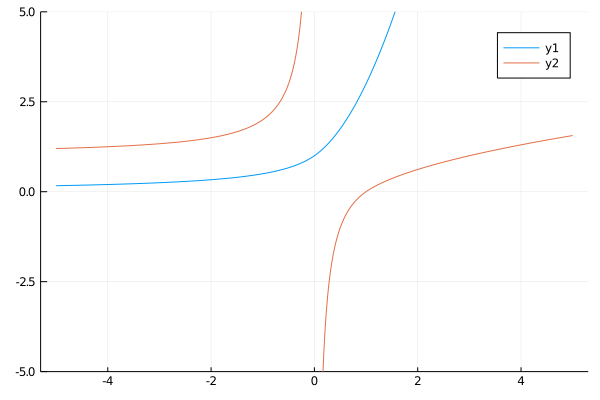

In [25]:
f, df, inv_f = Non_negative2()
x = -5:0.01:5
#plot(x, f.(inv_f.(x)))
#plot(x, inv_f.(f.(x)))
#plot(x, inv_f.(x))
#plot!(x, df(x))
plot(x, f.(x))
plot!(x, inv_f.(x), ylims=(-5,5 ))

In [26]:
#mg1img2 = convert(Array{Float32}, channelview(testimage("peppers_gray"))[1, :, :])
img1 = img
img2 = img_b 
img3 = img_noisy 
img4 = resGR2
img1_ft = abs.(fftshift(fft(img1)))
img2_ft = abs.(fftshift(fft(img2)))
img3_ft = abs.(fftshift(fft(img3)))
img4_ft = abs.(fftshift(fft(img4)))
N, _ = size(img1)
plot(img1_ft[N ÷ 2:400, N ÷ 2 + 1])
plot!(img2_ft[N ÷ 2:400, N ÷ 2 + 1])
plot!(img4_ft[N ÷ 2:400, N ÷ 2 + 1])
#imshowv(img1_ft, img2_ft, img3_ft, img4_ft)

UndefVarError: UndefVarError: resGR2 not defined

In [27]:
imshowv(img3, img2)

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>122: "map(clim-mapped image, inpu…
  "annotations" => 71: "input-60" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 70: "CLim" = CLim{Float32}(0.0, 1.11657) CLim{Float32} 

In [28]:
using Tullio, Einsum, LoopVectorization

function laplace_vec(rec)                                                           
    @views a = (rec[1:end-2, 2:end-1] .- 4 .* rec[2:end - 1, 2:end - 1]                
                .+ rec[3:end, 2:end - 1])                                           
    @views b = (rec[2:end-1, 1:end-2]                 
                .+ rec[2:end - 1, 3:end])                                           
                                                                                
    return @views sum((a .+ b) .^ 2)                                                   
end     


function laplace_for(rec)
    res = zero(eltype(rec))
    @avx for j = 2:size(rec)[2] - 1
        for i = 2:size(rec)[1] - 1
            @inbounds res += (rec[i - 1, j] + rec[i+1, j] 
                              + rec[i, j+1] + rec[i, j-1] - 4 * rec[i,j])^2
        end
    end
    return res
end
        

laplace_tul(rec) = @tullio res = (rec[i - 1, j] + rec[i + 1, j] +   
                                  rec[i, j + 1] + rec[i, j - 1] - 4 * rec[i,j])^2


laplace_tul (generic function with 1 method)

In [29]:
x = convert(Array{Float32}, 10 .+ randn(500, 500))
@time a = laplace_vec(x)
@time a = laplace_vec(x)
@time b = laplace_for(x)
@time b = laplace_for(x)
@time c = laplace_tul(x)
@time c = laplace_tul(x)


vec_tape_comp = ReverseDiff.compile(ReverseDiff.GradientTape(laplace_vec, x))
for_tape_comp = ReverseDiff.compile(ReverseDiff.GradientTape(laplace_for, x))

print("Zygote", "\n")
@time Zygote.gradient(laplace_vec, x)
@time Zygote.gradient(laplace_vec, x)
@time Zygote.gradient(laplace_tul, x)
@time Zygote.gradient(laplace_tul, x)
#@time ReverseDiff.gradient!(similar(x), vec_tape_comp, x);
#@time ReverseDiff.gradient!(similar(x), vec_tape_comp, x);
#@time ReverseDiff.gradient!(similar(x), for_tape_comp, x);
#@time ReverseDiff.gradient!(similar(x), for_tape_comp, x);
##@time Zygote.gradient(laplace_for, x)
#@time Zygote.gradient(laplace_for, x)

a ≈ b
a ≈ c

  0.573228 seconds (3.01 M allocations: 135.091 MiB, 6.26% gc time)
  0.000436 seconds (12 allocations: 2.839 MiB)
  1.963521 seconds (2.90 M allocations: 142.711 MiB, 3.26% gc time)
  0.000097 seconds (1 allocation: 16 bytes)
  0.513150 seconds (790.04 k allocations: 38.647 MiB)
  0.000110 seconds (12 allocations: 368 bytes)
Zygote
  2.685709 seconds (6.93 M allocations: 335.375 MiB)
  0.007601 seconds (174 allocations: 18.049 MiB)
  0.998026 seconds (1.29 M allocations: 64.055 MiB)
  0.001813 seconds (48 allocations: 977.891 KiB)


true

In [30]:
print(a, "\n", b, "\n", c)

4.949396e6
4.949395e6
4.949395e6

In [31]:
function L2norm_v(x)
    return sum(x .^ 2)
end

function L2norm_f(x)
    res = 0
    for j = 1:size(x)[2]
        for i = 1:size(x)[1]
            @inbounds res += x[i, j]^2
        end
    end
    return res
end

function L2norm_df(x)
    res = 0
    for j = 1:size(x)[2]
        for i = 1:size(x)[1]
            @inbounds res += 2 .* x[i, j]
        end
    end
    return res
end   

function L2norm_dv(x)
    return 2 .* x
end

x = rand(110, 100)

@time a = L2norm_v(x)
@time a = L2norm_v(x)
@time b = L2norm_f(x)
@time b = L2norm_f(x)
 
print("Zygote", "\n")
@time Zygote.gradient(L2norm_v, x)
@time Zygote.gradient(L2norm_v, x)
@time Zygote.gradient(L2norm_f, x)
@time Zygote.gradient(L2norm_f, x)

print("Analytic", "\n")
@time L2norm_dv(x)
@time L2norm_dv(x)
@time L2norm_df(x)
@time L2norm_df(x)


  0.021563 seconds (16.03 k allocations: 770.287 KiB)
  0.000037 seconds (3 allocations: 86.031 KiB)
  0.016778 seconds (24.67 k allocations: 1.267 MiB)
  0.000018 seconds (1 allocation: 16 bytes)
Zygote
  0.345280 seconds (742.01 k allocations: 33.789 MiB)
  0.000073 seconds (20 allocations: 172.359 KiB)
  8.161447 seconds (5.23 M allocations: 2.054 GiB, 51.21% gc time)
  0.321701 seconds (286.81 k allocations: 1.812 GiB, 15.83% gc time)
Analytic
  0.083063 seconds (316.65 k allocations: 15.320 MiB)
  0.000029 seconds (2 allocations: 86.016 KiB)
  0.035240 seconds (72.79 k allocations: 4.044 MiB)
  0.000017 seconds (1 allocation: 16 bytes)


10975.755574778257

In [32]:
M, K, N = 47, 73, 7;
A = rand(M, K);
b = rand(K);
c = rand(M);
d = rand(1,K,N);

E1 = Array{Float64}(undef, M, K, N);
E2 = similar(E1);

@time @. $E1 = exp($A - $b' +    $d) * $c
ldad = LowDimArray{(false,true,true)}(d);

@time @avx @. $E2 = exp($A - $b' + $ldad) * $c;

  0.275046 seconds (1.02 M allocations: 48.848 MiB)
  0.798855 seconds (1.27 M allocations: 65.422 MiB)


In [33]:
E2 ≈ E1

true

In [162]:
img3d = cat(img, dims=3);
img4d = cat(img3d, img3d ./ 2, img3d .* 2, dims=4);
img5d = cat(img4d, img4d ./ 2, img4d .* 2, dims=5);
#imshow(img3d)
print(size(img5d))

(512, 512, 1, 3, 3)

In [142]:
y=rfft(img5d, [1, 2, 3]);
print(size(y))

(257, 512, 1, 3, 3)

In [139]:
imshow(img5d[:, :, :, :, 1])

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>949: "map(clim-mapped image, inpu…
  "annotations" => 881: "input-357" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 880: "CLim" = CLim{Float32}(0.0823529, 0.968627) CLim{Float3…

In [141]:
imshow(real.(y[:, :, 1, :, 1]))

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>1059: "map(clim-mapped image, inp…
  "annotations" => 1008: "input-401" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 1007: "CLim" = CLim{Float32}(-12070.8, 106825.0) CLim{Float3…

In [169]:
img3d_2 = randn(size(img3d))
P = plan_rfft(img3d);
img3d_fft = P * img3d
P_inv = plan_irfft(img3d_fft, size(img3d)[1]);

img3d ≈ P_inv * (P * img3d)

img3d_2 ≈ P_inv * (P * img3d_2)

#size(P * img3d)
#size(P_inv * (P * img3d))

true